In [258]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold #removes all low-variance features.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


**READING THE CSV FILE**

In [259]:
df = pd.read_csv('https://raw.githubusercontent.com/Sneha8501/ML/main/Netflix_title_final.csv')
df.head()

,title,director,cast,country,date_added,rated by,listed_in,description,type,show_id,release_year,duration,rating
0,Chocolate - 1 Season,Toka McBaror,"Ha Ji-won, Yoon Kye-sang, Jang Seung-jo, Kang ...",South Korea,"November 30, 2019",TV-14,"International TV Shows, Korean TV Shows, Roman...",Brought together by meaningful meals in the pa...,TV Show,81193313,2019,60,6.3
1,Guatemala: Heart of the Mayan World,"Luis Ara, Ignacio Jaunsolo",Christian Morales,Unknown,"November 30, 2019",G,"Documentaries, International Movies","From Sierra de las Minas to Esquipulas, explor...",Movie,81197050,2019,67,7.2
2,The Zoya Factor,Abhishek Sharma,"Sonam Kapoor, Dulquer Salmaan, Sanjay Kapoor, ...",India,"November 30, 2019",TV-14,"Comedies, Dramas, International Movies",A goofy copywriter unwittingly convinces the I...,Movie,81213894,2019,135,7.2
3,Atlantics,Mati Diop,"Mama Sane, Amadou Mbow, Ibrahima Traore, Nicol...","France, Senegal, Belgium","November 29, 2019",TV-14,"Dramas, Independent Movies, International Movies","Arranged to marry a rich man, young Ada is cru...",Movie,81082007,2019,106,6.3
4,Chip and Potato - 2 Seasons,Frank Oz,"Abigail Oliver, Andrea Libman, Briana Buckmast...","Canada, United Kingdom","November 27, 2019",TV-Y,Kids' TV,"Lovable pug Chip starts kindergarten, makes ne...",TV Show,80213643,2019,60,7.7


In [260]:
fs=df.copy()
fs.shape

(985, 13)

**LABEL ENCODING**

In [261]:
label_encoder = preprocessing.LabelEncoder()
for column in fs:
  fs[column]= label_encoder.fit_transform(fs[column]) #Here categorical features are encoded and stored in the same dataframe fs

In [262]:
var_thres = VarianceThreshold(threshold=0)
var_thres.fit(fs)

VarianceThreshold(threshold=0)

In [263]:
var_thres.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [264]:
constant_columns=[column for column in fs.columns if column not in fs.columns[var_thres.get_support()]]
print(len(constant_columns))
constant_columns

0


[]

In [265]:
df.drop(constant_columns,axis=1,inplace=True)
df.shape

(985, 13)

In [266]:
df = df.T
print(df.duplicated().sum())
df = df.T

0


In [267]:
fs.corr()

,title,director,cast,country,date_added,rated by,listed_in,description,type,show_id,release_year,duration,rating
title,1.000000,0.002300,0.074846,0.020655,0.005145,0.018827,-0.034812,0.060331,-0.007337,-0.092970,-0.073743,0.062053,-0.012732
director,0.002300,1.000000,-0.044015,-0.012502,-0.021517,0.111823,0.096033,0.001448,0.386032,0.052112,0.021618,-0.224746,-0.040688
cast,0.074846,-0.044015,1.000000,-0.033956,-0.010441,0.008963,0.034817,-0.023193,0.003884,0.047997,-0.008971,0.063190,0.027670
country,0.020655,-0.012502,-0.033956,1.000000,0.059006,-0.114396,0.006537,0.044260,0.047698,-0.272086,-0.169149,-0.180636,0.001502
date_added,0.005145,-0.021517,-0.010441,0.059006,1.000000,-0.072702,-0.071701,-0.035813,-0.074119,0.021988,-0.052177,0.090292,-0.031433
rated by,0.018827,0.111823,0.008963,-0.114396,-0.072702,1.000000,0.268592,-0.007346,0.227355,0.294901,0.253872,-0.122537,-0.000689
listed_in,-0.034812,0.096033,0.034817,0.006537,-0.071701,0.268592,1.000000,-0.047119,0.272793,0.237928,0.211475,-0.262196,0.007596
description,0.060331,0.001448,-0.023193,0.044260,-0.035813,-0.007346,-0.047119,1.000000,0.000238,-0.106223,-0.073769,-0.074531,-0.020373
type,-0.007337,0.386032,0.003884,0.047698,-0.074119,0.227355,0.272793,0.000238,1.000000,0.078056,0.072817,-0.459747,-0.012297
show_id,-0.092970,0.052112,0.047997,-0.272086,0.021988,0.294901,0.237928,-0.106223,0.078056,1.000000,0.643977,-0.183813,0.017506


In [268]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(fs, 0.4)
len(set(corr_features))

2

In [269]:
corr_features

{'duration', 'release_year'}

In [270]:
df.drop(corr_features, axis=1, inplace = True)
df.shape

(985, 11)

**Inference** - Drama appears to be the most popular genre followed by Comedy

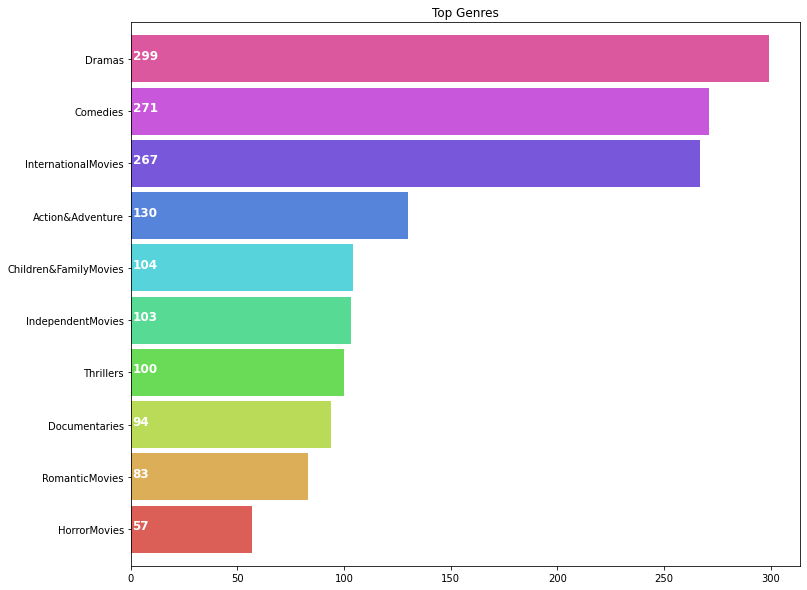

In [271]:
df['listed_in'] = df['listed_in'].str.strip('[]').str.replace(' ','').str.replace("'",'') #Cleaning the listed_in column to find the list of genres
df['listed_in'] = df['listed_in'].str.split(',')

#plotting the genres in terms of their occurrence to get an insight into movie genres in terms of popularity.
plt.subplots(figsize=(12,10))
list1 = []
for i in df['listed_in']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

In [272]:
for i,j in zip(df['listed_in'],df.index):
    list2=[]
    list2=i
    list2.sort()
    df.loc[j,'listed_in']=str(list2)
df['listed_in'] = df['listed_in'].str.strip('[]').str.replace(' ','').str.replace("'",'')
df['listed_in'] = df['listed_in'].str.split(',')
genreList = []
for index, row in df.iterrows():
    listed_in = row["listed_in"]
    
    for genre in listed_in:
        if genre not in genreList:
            genreList.append(genre)
genreList[:10] #now we have a list with unique genres 

def binary(genre_list): #Applying the binary() function to the genres column to get the genre_list
    binaryList = []
    
    for genre in genreList:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

df['genres_bin'] = df['listed_in'].apply(lambda x: binary(x))
df['genres_bin'].head()

0    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
Name: genres_bin, dtype: object

In [273]:
df['cast'] = df['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
df['cast'] = df['cast'].str.split(',')

for i,j in zip(df['cast'],df.index):
    list2 = []
    list2 = i[:4]
    df.loc[j,'cast'] = str(list2)
df['cast'] = df['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'')
df['cast'] = df['cast'].str.split(',')
for i,j in zip(df['cast'],df.index):
    list2 = []
    list2 = i
    list2.sort()
    df.loc[j,'cast'] = str(list2)
df['cast']=df['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'')

castList = [] #now we have a list with unique cast of the movies
for index, row in df.iterrows():
    cast = row["cast"]
    
    for i in cast:
        if i not in castList:
            castList.append(i)

def binary(cast_list): #Applying the binary() function to the cast column to get the cast_list
    binaryList = []
    
    for genre in castList:
        if genre in cast_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

df['cast_bin'] = df['cast'].apply(lambda x: binary(x))
df['cast_bin'].head()

0    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
1    [0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, ...
2    [0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...
3    [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...
4    [0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, ...
Name: cast_bin, dtype: object

In [274]:
df['director'] = df['director'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
df['director'] = df['director'].str.split(',')
def xstr(s):
    if s is None:
        return ''
    return str(s)
df['director'] = df['director'].apply(xstr)

directorList=[] #now we have a list with unique directors of movies and TV shows
for i in df['director']:
    if i not in directorList:
        directorList.append(i)

def binary(director_list): #Applying the binary() function to the director column to get the director_list
    binaryList = []  
    for direct in directorList:
        if direct in director_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList

df['director_bin'] = df['director'].apply(lambda x: binary(x))
df['director_bin'].head()

0    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: director_bin, dtype: object

In [275]:
def xstr(s):
    if s is None:
        return ''
    return str(s)
df['rated by'] = df['rated by'].apply(xstr)

ratedbyList=[] #now we have a list with unique values of rated by
for i in df['rated by']:
    if i not in ratedbyList:
        ratedbyList.append(i)

def binary(ratedby_list):  #Applying the binary() function to the rated by column to get the rated by_list
    binaryList = []  
    for rated in ratedbyList:
        if rated in ratedby_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList

df['rated by_bin'] = df['rated by'].apply(lambda x: binary(x))
df['rated by_bin'].head()

0    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
2    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Name: rated by_bin, dtype: object

In [276]:
def xstr(s):
    if s is None:
        return ''
    return str(s)
df['country'] = df['country'].apply(xstr)

countryList=[] #now we have a list with unique countries where the movies or TV shows are released
for i in df['country']:
    if i not in countryList:
        countryList.append(i)

def binary(country_list): #Applying the binary() function to the country list column to get the country_list
    binaryList = []  
    for count in countryList:
        if count in country_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList

df['country_bin'] = df['country'].apply(lambda x: binary(x))
df['country_bin'].head()

0    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
4    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: country_bin, dtype: object

In [277]:
def xstr(s):
    if s is None:
        return ''
    return str(s)
df['type'] = df['type'].apply(xstr)

typeList=[] #now we have a list with unique type i.e, movies or TV shows
for i in df['type']:
    if i not in typeList:
        typeList.append(i)

def binary(type_list): #Applying the binary() function to the type list column to get the type_list
    binaryList = []  
    for ty in typeList:
        if ty in type_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList

df['type_bin'] = df['type'].apply(lambda x: binary(x))
df['type_bin'].head()

0    [1, 0]
1    [0, 1]
2    [0, 1]
3    [0, 1]
4    [1, 0]
Name: type_bin, dtype: object

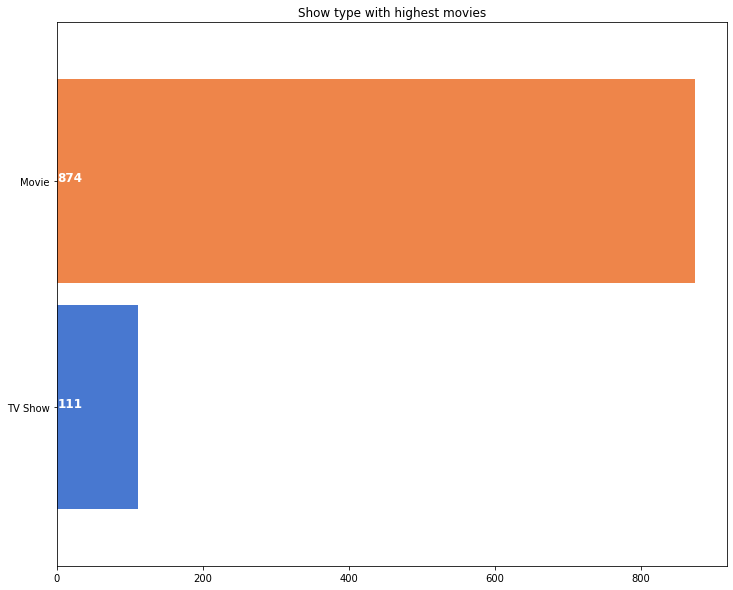

In [278]:
plt.subplots(figsize=(12,10))
ax = df[df['type']!=''].type.value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(df[df['type']!=''].type.value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
plt.title('Show type with highest movies')
plt.show()

**INFERENCE:** There are more number of Movies than TV shows

In [279]:
df.head()

,title,director,cast,country,date_added,rated by,listed_in,description,type,show_id,rating,genres_bin,cast_bin,director_bin,rated by_bin,country_bin,type_bin
0,Chocolate - 1 Season,['TokaMcBaror'],"HaJi-won,JangSeung-jo,KangBu-ja,YoonKye-sang",South Korea,"November 30, 2019",TV-14,"[InternationalTVShows, KoreanTVShows, Romantic...",Brought together by meaningful meals in the pa...,TV Show,81193313,6.3,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0]"
1,Guatemala: Heart of the Mayan World,"['LuisAra', 'IgnacioJaunsolo']",ChristianMorales,Unknown,"November 30, 2019",G,"[Documentaries, InternationalMovies]","From Sierra de las Minas to Esquipulas, explor...",Movie,81197050,7.2,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1]"
2,The Zoya Factor,['AbhishekSharma'],"DulquerSalmaan,SanjayKapoor,SikanderKher,Sonam...",India,"November 30, 2019",TV-14,"[Comedies, Dramas, InternationalMovies]",A goofy copywriter unwittingly convinces the I...,Movie,81213894,7.2,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1]"
3,Atlantics,['MatiDiop'],"AmadouMbow,IbrahimaTraore,MamaSane,NicoleSougou","France, Senegal, Belgium","November 29, 2019",TV-14,"[Dramas, IndependentMovies, InternationalMovies]","Arranged to marry a rich man, young Ada is cru...",Movie,81082007,6.3,"[0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1]"
4,Chip and Potato - 2 Seasons,['FrankOz'],"AbigailOliver,AndreaLibman,BrianDobson,BrianaB...","Canada, United Kingdom","November 27, 2019",TV-Y,[KidsTV],"Lovable pug Chip starts kindergarten, makes ne...",TV Show,80213643,7.7,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0]"


In [280]:
from scipy import spatial
#We use Cosine Similarity for finding the similarity between 2 movies(based on the distance).
def Similarity(movieId1, movieId2):#The function similarity which will check the similarity between the movies.
    a = df.iloc[movieId1]
    b = df.iloc[movieId2]
    
    genresA = a['genres_bin']
    genresB = b['genres_bin']
    
    genreDistance = spatial.distance.cosine(genresA, genresB)

    scoreA = a['cast_bin']
    scoreB = b['cast_bin']
    scoreDistance = spatial.distance.cosine(scoreA, scoreB)
    
    directA = a['director_bin']
    directB = b['director_bin']
    directDistance = spatial.distance.cosine(directA, directB)

    ratedA = a['rated by_bin']
    ratedB = b['rated by_bin']
    ratedDistance = spatial.distance.cosine(ratedA, ratedB)

    countryA = a['country_bin']
    countryB = b['country_bin']
    countryDistance = spatial.distance.cosine(countryA, countryB)

    typeA = a['type_bin']
    typeB = b['type_bin']
    typeDistance = spatial.distance.cosine(typeA, typeB)
     
    l=[genreDistance,directDistance,scoreDistance,ratedDistance,countryDistance,typeDistance]
    m = min(l)
    min_index = l.index(m)
    
    return genreDistance + directDistance + scoreDistance + ratedDistance + countryDistance + typeDistance , min_index

In [281]:
r,r1=Similarity(3,160) #checking similarity between any 2 random movies
#The more the distance, the less similar the movies are
print(r)

4.3907282041550575


In [282]:
#We see that the distance is about 4.3907282041550575, which is high.
##It is evident that they are very different movies. Thus the distance is huge.
print(df.iloc[3])
print(df.iloc[160])

title                                                   Atlantics
director                                             ['MatiDiop']
cast              AmadouMbow,IbrahimaTraore,MamaSane,NicoleSougou
country                                  France, Senegal, Belgium
date_added                                      November 29, 2019
rated by                                                    TV-14
listed_in        [Dramas, IndependentMovies, InternationalMovies]
description     Arranged to marry a rich man, young Ada is cru...
type                                                        Movie
show_id                                                  81082007
rating                                                        6.3
genres_bin      [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
cast_bin        [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...
director_bin    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
rated by_bin                       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
country_bi

In [283]:
new_id = list(range(0,df.shape[0]))
df['new_id']=new_id
df=df[['show_id','new_id','title','listed_in','genres_bin','rating','cast','cast_bin','director','director_bin','type','type_bin','country','country_bin','rated by','rated by_bin']]
df.head()

,show_id,new_id,title,listed_in,genres_bin,rating,cast,cast_bin,director,director_bin,type,type_bin,country,country_bin,rated by,rated by_bin
0,81193313,0,Chocolate - 1 Season,"[InternationalTVShows, KoreanTVShows, Romantic...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.3,"HaJi-won,JangSeung-jo,KangBu-ja,YoonKye-sang","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",['TokaMcBaror'],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",TV Show,"[1, 0]",South Korea,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",TV-14,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,81197050,1,Guatemala: Heart of the Mayan World,"[Documentaries, InternationalMovies]","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.2,ChristianMorales,"[0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, ...","['LuisAra', 'IgnacioJaunsolo']","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Movie,"[0, 1]",Unknown,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",G,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,81213894,2,The Zoya Factor,"[Comedies, Dramas, InternationalMovies]","[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.2,"DulquerSalmaan,SanjayKapoor,SikanderKher,Sonam...","[0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",['AbhishekSharma'],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Movie,"[0, 1]",India,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",TV-14,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,81082007,3,Atlantics,"[Dramas, IndependentMovies, InternationalMovies]","[0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",6.3,"AmadouMbow,IbrahimaTraore,MamaSane,NicoleSougou","[0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...",['MatiDiop'],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Movie,"[0, 1]","France, Senegal, Belgium","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",TV-14,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,80213643,4,Chip and Potato - 2 Seasons,[KidsTV],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",7.7,"AbigailOliver,AndreaLibman,BrianDobson,BrianaB...","[0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, ...",['FrankOz'],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",TV Show,"[1, 0]","Canada, United Kingdom","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",TV-Y,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [284]:
data1 = pd.DataFrame(columns=['Title','Genre','Rating','Reason'])

In [285]:
import operator
def predict_score(name):
    #name = input('Enter a movie title: ')
    new_movie = df[df['title'].str.contains(name)].iloc[0].to_frame().T
    print('Selected Movie: ',new_movie.title.values[0])

    def getNeighbors(baseMovie, K):
        distances = []
        reason_list =[]
    
        for index, movie in df.iterrows():
            if movie['new_id'] != baseMovie['new_id'].values[0]:
                dist,reason = Similarity(baseMovie['new_id'].values[0], movie['new_id'])
                distances.append((movie['new_id'], dist))
                reason_list.append(reason)
    
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors,reason_list
        
    K = 10
    avgRating = 0
    reason=[]
    neighbors,rea = getNeighbors(new_movie, K)
    for i in range(0,len(rea)):
        if rea[i] == 0:
            reason.append('Due to commanality in genre')
        elif rea[i] == 1:
            reason.append('Due to commanality in director')
        elif rea[i] == 2:
            reason.append('Due to commanality in cast')
        elif rea[i] == 3:
            reason.append('Due to commanality in rated by')
        elif rea[i] == 4:
            reason.append('Due to commanality in country')
        else:
            reason.append('Due to commanality in the type of show')
  
    print('\nRecommended Movies: \n')
    z=0
    for neighbor in neighbors:
        avgRating = avgRating+df.iloc[neighbor[0]][5]  
        data1.loc[z,'Title']=df.iloc[neighbor[0]][2]
        data1.loc[z,'Genre']=str(df.iloc[neighbor[0]][3]).strip('[]').replace(' ','')
        data1.loc[z,'Rating']=df.iloc[neighbor[0]][5]
        data1.loc[z,'Reason']=reason[z]
        z=z+1
    avgRating = avgRating/K
    return data1,avgRating,new_movie
    

In [286]:
data1,avgRating,new_movie = predict_score('Atlantics')#10 similar movies are recommended with ratings along with the reason for the recommendation
data1.head(10)

Selected Movie:  Atlantics

Recommended Movies: 



,Title,Genre,Rating,Reason
0,The Man Without Gravity,"'Dramas','InternationalMovies'",9.1,Due to commanality in rated by
1,Saavat,"'Dramas','IndependentMovies','InternationalMov...",7.8,Due to commanality in the type of show
2,300 Miles to Heaven,"'Dramas','InternationalMovies'",8,Due to commanality in rated by
3,Saawan,"'Dramas','IndependentMovies','InternationalMov...",7.4,Due to commanality in cast
4,Jonaki,"'Dramas','IndependentMovies','InternationalMov...",7.3,Due to commanality in rated by
5,Hamid,"'Dramas','IndependentMovies','InternationalMov...",9.8,Due to commanality in the type of show
6,Do Paise Ki Dhoop Chaar Aane Ki Baarish,"'Dramas','IndependentMovies','InternationalMov...",7.7,Due to commanality in rated by
7,Master Z: The Ip Man Legacy,"'Dramas','IndependentMovies','InternationalMov...",7.8,Due to commanality in the type of show
8,Kia and Cosmos,"'Dramas','IndependentMovies','InternationalMov...",6.8,Due to commanality in rated by
9,In My Country,"'Dramas','InternationalMovies'",6.8,Due to commanality in rated by


In [287]:
print('The predicted rating for %s is: %f' %(new_movie['title'].values[0],avgRating))
print('The actual rating for %s is %f' %(new_movie['title'].values[0],new_movie['rating']))

The predicted rating for Atlantics is: 7.850000
The actual rating for Atlantics is 6.300000


In [288]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [289]:
df = pd.read_csv('https://raw.githubusercontent.com/Sneha8501/ML/main/Netflix_title_final.csv')
df.head()

,title,director,cast,country,date_added,rated by,listed_in,description,type,show_id,release_year,duration,rating
0,Chocolate - 1 Season,Toka McBaror,"Ha Ji-won, Yoon Kye-sang, Jang Seung-jo, Kang ...",South Korea,"November 30, 2019",TV-14,"International TV Shows, Korean TV Shows, Roman...",Brought together by meaningful meals in the pa...,TV Show,81193313,2019,60,6.3
1,Guatemala: Heart of the Mayan World,"Luis Ara, Ignacio Jaunsolo",Christian Morales,Unknown,"November 30, 2019",G,"Documentaries, International Movies","From Sierra de las Minas to Esquipulas, explor...",Movie,81197050,2019,67,7.2
2,The Zoya Factor,Abhishek Sharma,"Sonam Kapoor, Dulquer Salmaan, Sanjay Kapoor, ...",India,"November 30, 2019",TV-14,"Comedies, Dramas, International Movies",A goofy copywriter unwittingly convinces the I...,Movie,81213894,2019,135,7.2
3,Atlantics,Mati Diop,"Mama Sane, Amadou Mbow, Ibrahima Traore, Nicol...","France, Senegal, Belgium","November 29, 2019",TV-14,"Dramas, Independent Movies, International Movies","Arranged to marry a rich man, young Ada is cru...",Movie,81082007,2019,106,6.3
4,Chip and Potato - 2 Seasons,Frank Oz,"Abigail Oliver, Andrea Libman, Briana Buckmast...","Canada, United Kingdom","November 27, 2019",TV-Y,Kids' TV,"Lovable pug Chip starts kindergarten, makes ne...",TV Show,80213643,2019,60,7.7


In [290]:
rating_mean = df.groupby('title')['rating'].mean().reset_index()
total_rating = df.groupby('title')['rating'].count().reset_index()

total_rating_mean = pd.merge(rating_mean, total_rating, on='title', how='inner')
total_rating_mean.rename(columns={'rating_x': 'rating_mean',
                                  'rating_y': 'total_rating'},
                                  inplace=True)
# final_df = (total_rating_mean, on='title', how='left',usecols = ['show_id']).dropna()
final_df = total_rating_mean

final_df = final_df.join(df['show_id'], how='right')
final_df = final_df.join(df['rated by'], how='right').dropna()
final_df = final_df.join(df['listed_in'], how='right').dropna()
final_df.head

<bound method NDFrame.head of                                    title  ...                                          listed_in
0                                #Selfie  ...  International TV Shows, Korean TV Shows, Roman...
1                             #Selfie 69  ...                Documentaries, International Movies
2                    10 Days in Sun City  ...             Comedies, Dramas, International Movies
3                            10,000 B.C.  ...   Dramas, Independent Movies, International Movies
4    100 Things to do Before High School  ...                                           Kids' TV
..                                   ...  ...                                                ...
978                                 Zero  ...                                  Dramas, Thrillers
979                              Zinzana  ...          Comedies, International Movies, Thrillers
980                               Zodiac  ...                                           TV Shows


In [291]:
feature_cols =['show_id','total_rating']
X = final_df[feature_cols] # Features
y = final_df['rating_mean']

In [292]:
regressor.fit(X, y) 

RandomForestRegressor(random_state=0)

In [293]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(X,y, test_size = 0.33, random_state = 42)

In [294]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (658, 2)
Training Labels Shape: (658,)
Testing Features Shape: (325, 2)
Testing Labels Shape: (325,)


In [295]:
predictions = regressor.predict(test_features)
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.5 degrees.


In [296]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.64 %.


In [297]:
data = pd.read_csv('https://raw.githubusercontent.com/Sneha8501/ML/main/Netflix_title_final1.csv')
data.rename( columns={'Unnamed: 0':'movie_index'}, inplace=True )
data.head(5)

,movie_index,title,director,cast,country,date_added,rated by,listed_in,description,type,show_id,release_year,duration,rating
0,0,Chocolate - 1 Season,Toka McBaror,"Ha Ji-won, Yoon Kye-sang, Jang Seung-jo, Kang ...",South Korea,"November 30, 2019",TV-14,"International TV Shows, Korean TV Shows, Roman...",Brought together by meaningful meals in the pa...,TV Show,81193313,2019,60,6.3
1,1,Guatemala: Heart of the Mayan World,"Luis Ara, Ignacio Jaunsolo",Christian Morales,Unknown,"November 30, 2019",G,"Documentaries, International Movies","From Sierra de las Minas to Esquipulas, explor...",Movie,81197050,2019,67,7.2
2,2,The Zoya Factor,Abhishek Sharma,"Sonam Kapoor, Dulquer Salmaan, Sanjay Kapoor, ...",India,"November 30, 2019",TV-14,"Comedies, Dramas, International Movies",A goofy copywriter unwittingly convinces the I...,Movie,81213894,2019,135,7.2
3,3,Atlantics,Mati Diop,"Mama Sane, Amadou Mbow, Ibrahima Traore, Nicol...","France, Senegal, Belgium","November 29, 2019",TV-14,"Dramas, Independent Movies, International Movies","Arranged to marry a rich man, young Ada is cru...",Movie,81082007,2019,106,6.3
4,4,Chip and Potato - 2 Seasons,Frank Oz,"Abigail Oliver, Andrea Libman, Briana Buckmast...","Canada, United Kingdom","November 27, 2019",TV-Y,Kids' TV,"Lovable pug Chip starts kindergarten, makes ne...",TV Show,80213643,2019,60,7.7


In [298]:
columns=['cast','director','listed_in','title']
data[columns].head()

,cast,director,listed_in,title
0,"Ha Ji-won, Yoon Kye-sang, Jang Seung-jo, Kang ...",Toka McBaror,"International TV Shows, Korean TV Shows, Roman...",Chocolate - 1 Season
1,Christian Morales,"Luis Ara, Ignacio Jaunsolo","Documentaries, International Movies",Guatemala: Heart of the Mayan World
2,"Sonam Kapoor, Dulquer Salmaan, Sanjay Kapoor, ...",Abhishek Sharma,"Comedies, Dramas, International Movies",The Zoya Factor
3,"Mama Sane, Amadou Mbow, Ibrahima Traore, Nicol...",Mati Diop,"Dramas, Independent Movies, International Movies",Atlantics
4,"Abigail Oliver, Andrea Libman, Briana Buckmast...",Frank Oz,Kids' TV,Chip and Potato - 2 Seasons


In [299]:
def get_important_features(data1):
  important_features = []
  for i in range(0,data1.shape[0]):
    important_features.append(data1['cast'][i]+' '+data1['director'][i]+' '+data1['listed_in'][i]+' '+data1['title'][i])
  
  return important_features

In [300]:
data['important_features']=get_important_features(data)
cm=CountVectorizer().fit_transform(data['important_features'])

In [301]:
cs = cosine_similarity(cm)
print(cm)

  (0, 1284)	1
  (0, 1679)	1
  (0, 3526)	1
  (0, 3540)	1
  (0, 4096)	1
  (0, 4166)	1
  (0, 4192)	1
  (0, 4225)	1
  (0, 4318)	1
  (0, 4336)	1
  (0, 4348)	1
  (0, 4531)	1
  (0, 4752)	1
  (0, 4849)	1
  (0, 4940)	1
  (0, 5090)	1
  (0, 5755)	1
  (0, 5991)	1
  (0, 7529)	1
  (0, 7633)	1
  (0, 7776)	1
  (0, 7934)	1
  (0, 8005)	1
  (0, 8169)	3
  (0, 8795)	1
  :	:
  (983, 9581)	1
  (984, 405)	1
  (984, 929)	1
  (984, 1522)	1
  (984, 1815)	1
  (984, 3021)	1
  (984, 3058)	1
  (984, 3740)	1
  (984, 4583)	1
  (984, 5087)	1
  (984, 7432)	1
  (984, 7497)	2
  (984, 7725)	1
  (984, 7729)	1
  (984, 7934)	1
  (984, 8164)	1
  (984, 8533)	1
  (984, 8849)	1
  (984, 8889)	3
  (984, 9098)	1
  (984, 9150)	1
  (984, 9542)	1
  (984, 9544)	1
  (984, 9578)	1
  (984, 9728)	1


In [302]:
cs.shape

(985, 985)

In [303]:
title1='Atlantics'
movie_id = data[data['title'] == title1]['movie_index'].values[0]
scores=list(enumerate(cs[movie_id]))

In [304]:
sorted_scores = sorted(scores,key = lambda x:x[1],reverse=True)
sorted_scores=sorted_scores[1:]
print(sorted_scores)

[(48, 0.3415650255319866), (667, 0.3299831645537221), (768, 0.3099652099390333), (947, 0.30123203803835463), (886, 0.2788866755113585), (982, 0.2788866755113585), (38, 0.27386127875258304), (505, 0.272474630456533), (27, 0.26648544566940835), (483, 0.26648544566940835), (597, 0.2581988897471611), (434, 0.2506402059138015), (329, 0.2459549291242073), (877, 0.2459549291242073), (241, 0.24152294576982392), (967, 0.24152294576982392), (348, 0.2373222262672836), (738, 0.2373222262672836), (200, 0.23354968324845685), (887, 0.23333333333333328), (866, 0.2295390425243835), (43, 0.22592402852876597), (710, 0.22592402852876597), (8, 0.223606797749979), (651, 0.22247460415730486), (737, 0.22140372138502382), (100, 0.2201927530252721), (681, 0.21917850187980228), (863, 0.21917850187980228), (74, 0.21908902300206645), (897, 0.21602468994692864), (46, 0.21516574145596762), (316, 0.21516574145596762), (375, 0.21516574145596762), (132, 0.21483446221182984), (450, 0.21300321680756457), (755, 0.20942695

In [305]:
j=0
print("10 most recommended movie to ",title1, 'are:\n')
print("Users who watched "+title1+" also watched these movies \n" )
for item in sorted_scores:
  movie_title = data[data.movie_index == item[0]]['title'].values[0]
  rating = data[data.movie_index == item[0]]['rating'].values[0]
  print(j+1,"\t",movie_title," ",rating)
  j=j+1
  if j > 9:
    break
  


10 most recommended movie to  Atlantics are:

Users who watched Atlantics also watched these movies 

1 	 Love, Rosie   8.0
2 	 Good Night, and Good Luck   9.8
3 	 C Kkompany   6.8
4 	 Like Arrows   8.9
5 	 Once Upon a Time in Mumbai Dobaara!   7.6
6 	 Hong Kong West Side Stories - 1 Season   9.1
7 	 Carriers   7.9
8 	 Invader Zim: Enter the Florpus   7.2
9 	 The Time Machine   7.9
10 	 Falling Inn Love   6.8
